Lab02
=====

###  Context
#### Convolution Layer Visualization

이번 실습에서는 Convolution Layer가 이미지의 어떤 특징들을 인식하는지 살펴보겠습니다.<br>

In [7]:
from os.path import join

import numpy as np

import tensorflow as tf
import keras
from keras import layers, models, Input
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# join 함수는 운영체제마다 경로 구분자가 달라 생길 수 있는 경로 오류를 피할 수 있습니다.
datapath = join('data','MNIST')

In [8]:
# Keras 백 엔드인 TensorFlow의 세션 설정을 불러옵니다.
from keras.backend.tensorflow_backend import set_session

# TensorFlow의 ConfigProto() 객체에 학습시 적용할 옵션들을 명시적으로 설정할 수 있습니다.
config = tf.ConfigProto()
# GPU 옵션으로 allow_grouth를 True로 설정합니다.
config.gpu_options.allow_growth = True 

# TensorFlow는 Session이라는 실행 단위를 가지고 있는데, 해당 Session이라는에 적용할 옵션을 담고있는 Config객체를 전달합니다.
sess = tf.Session(config=config)
# 설정한 Session이라는을 현재 프로세스에 적용합니다.
set_session(sess)  

## 1. 데이터 살펴보기
이번에 사용할 데이터는 손글씨 데이터로 유명한 MNIST 데이터 입니다.<br>
MNIST(Modified National Institute of Standards and Technology database)는 손으로 쓴 숫자들로 이루어진 대형 데이터셋 입니다.<br>
일반적으로 다양한 영상 처리 시스템을 트레이닝하기 위해 사용됩니다. 또한, 기계 학습 분야의 학습 및 검증에 널리 사용된다. <br>
MNIST 데이터셋은 28x28 픽셀의 흑백(Gray scale) 이미지입니다.<br>

![MNIST](./Images/MNIST.png)

data 디렉토리에 준비된 데이터와 라벨을 가져옵니다.<br>

In [9]:
# 데이터를 불러옵니다.
x = np.load(join(datapath, 'MNIST.npy'))
y = np.load(join(datapath, 'Label.npy'))

## 2. 간단한 전처리
MNIST 데이터는 28\*28에 픽셀마다 0~255 범위의 값을 가진 행렬입니다. <br>
각 픽셀에 대해 0~1 사이의 값을 갖도록 255로 나누어줍니다.<br><br>

CNN은 입력 데이터가 채널, 즉 이미지에서의 RGB 채널을 가지고 있어야하는데, MNIST 데이터는 28\*28의 이미지입니다.<br>
numpy.reshape() 함수를 통해 28\*28\*1 로 차원을 변경해줍니다.

In [10]:
#0~1 사이의 값으로 변경
x = x / 255

print(x.shape)

x = x.reshape(len(x), 28, 28, 1)

#값이 잘 변화되었는지 확인
print('최대 : {}, 최소 : {}'.format(np.max(x), np.min(x)))

(60000, 28, 28)
최대 : 1.0, 최소 : 0.0


이미지들의 정답을 나타내는 label 데이터는 0~9의 값을 가지고 있습니다.<br>
해당 label 데이터도 독립적인 벡터 형태로 표현하겠습니다.

### 왜 벡터를 사용하나요
여기에서 Label 데이터를 그대로 숫자로 표현해도 되지만, 벡터로 표현한 것은 숫자 이미지라는 특성이 수치적으로 1씩 증가하는 관계가 아니기 때문에<br>
서로 독립적인 관계를 갖는 벡터로 표현해주는 것이 더 적절합니다. 이러한 기법을 One-hot encoding이라 합니다.<br>
Keras에서는 연속 정수형을 벡터형태로 변환해주는 to_categorical() 함수가 존재합니다.

In [11]:
y = to_categorical(y)
print(y[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


데이터를 훈련 데이터와, 검증 데이터로 나눕니다.

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2,
                                                    random_state=2019,
                                                    shuffle=True)

통과한 이미지를 살펴보기위해 간단한 CNN을 작성해보겠습니다.

In [13]:
# parameters
epoch = 5
batch_size = 512

In [14]:
# 입력층
input_size = (28, 28, 1)
input_tensor = Input(shape=input_size)

# 은닉층 
X = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(input_tensor)
X = layers.MaxPooling2D()(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = layers.MaxPooling2D()(X)
X = layers.BatchNormalization()(X)

X = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(X)
X = layers.MaxPooling2D()(X)
X = layers.BatchNormalization()(X)

X = layers.Flatten()(X)

X = layers.Dense(64,activation = 'relu')(X)
X = layers.Dropout(0.25)(X)
X = layers.Dense(32,activation = 'relu')(X)
X = layers.Dropout(0.25)(X)

# 출력층
output_tensor = layers.Dense(10,activation = 'softmax')(X)

# 모델 정의
model = models.Model(input_tensor, output_tensor)
# 모델 생성(컴파일), Optimizer는 Adam, 비용 함수는 10개 클래스 분류이므로 categorical_crossentropy를 사용합니다.
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [15]:
# 모델 구조 확인
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
__________

In [16]:
# 학습 시작
history = model.fit(x_train, y_train,
         validation_data = [x_test, y_test],
         epochs=epoch,
         batch_size=batch_size,
         verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
 - 46s - loss: 0.6791 - acc: 0.7818 - val_loss: 0.1214 - val_acc: 0.9639
Epoch 2/5
 - 45s - loss: 0.1387 - acc: 0.9620 - val_loss: 0.1029 - val_acc: 0.9703
Epoch 3/5
 - 45s - loss: 0.0877 - acc: 0.9754 - val_loss: 0.0837 - val_acc: 0.9754
Epoch 4/5
 - 45s - loss: 0.0620 - acc: 0.9831 - val_loss: 0.0494 - val_acc: 0.9865
Epoch 5/5
 - 46s - loss: 0.0503 - acc: 0.9853 - val_loss: 0.0477 - val_acc: 0.9863


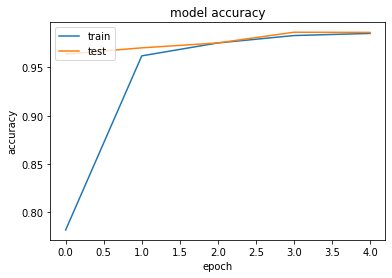

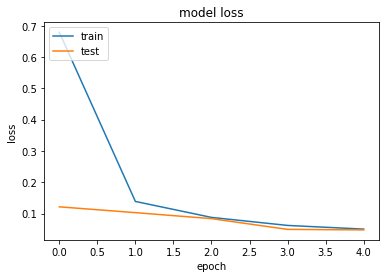

In [17]:
# 정확도 그래프를 그립니다.
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 비용 함수 그래프를 그립니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

여기까지는 이전과 동일하게 작성된 코드입니다. 이제 각 Convolution 층의 출력을 살펴보기위해 층을 하나하나 나눠보겠습니다.<br>
keras는 model.layers 라는 함수로 해당 모델에 들어있는 층을 리스트로 반환할 수 있습니다.<br>
그리고 각각의 층은 layer.output으로 출력을 반환할 수 있습니다. 이를 이용해 같은 입력에 대해 다른 출력을 만드는 새로운 모델을 만들겠습니다.

In [18]:
# 작성한 CNN 모델의 각 층을 리스트로 변환합니다.
layer_outputs = [layer.output for layer in model.layers]

# 작성한 CNN 모델과 동일한 입력을 사용하고, 각 레이어마다 출력을 뽑을 수 있는 모델을 생성합니다.
# 이런식으로 모델을 작성하면, 해당 모델은 predict 함수로 여러개의 출력을 리스트로  반환합니다.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

# 10번 인덱스의 이미지를 넣어 각 층의 출력값을 저장합니다. (출력층이 여러개이므로, 여러개의 출력을 리스트로 반환합니다.)
activations = activation_model.predict(x_train[10].reshape(1,28,28,1))

# act_index : 확인하고자 하는 Convolution Layer의 번호
# act_index에 맞게 해당 층의 모든 filter를 시각화 해주는 함수입니다.
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

In [19]:
# 모델의 구조를 다시 한번 보겠습니다.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
__________

컴퓨터는 0부터 숫자가 시작하므로, 우리가 확인해보고싶은 Convolution 층들의 인덱스는 1, 4, 7 3개 인덱스입니다. 확인해보겠습니다.

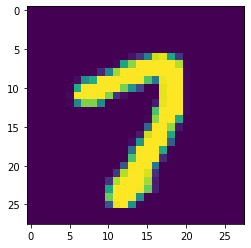

In [20]:
plt.imshow(x_train[10].reshape((28, 28)));

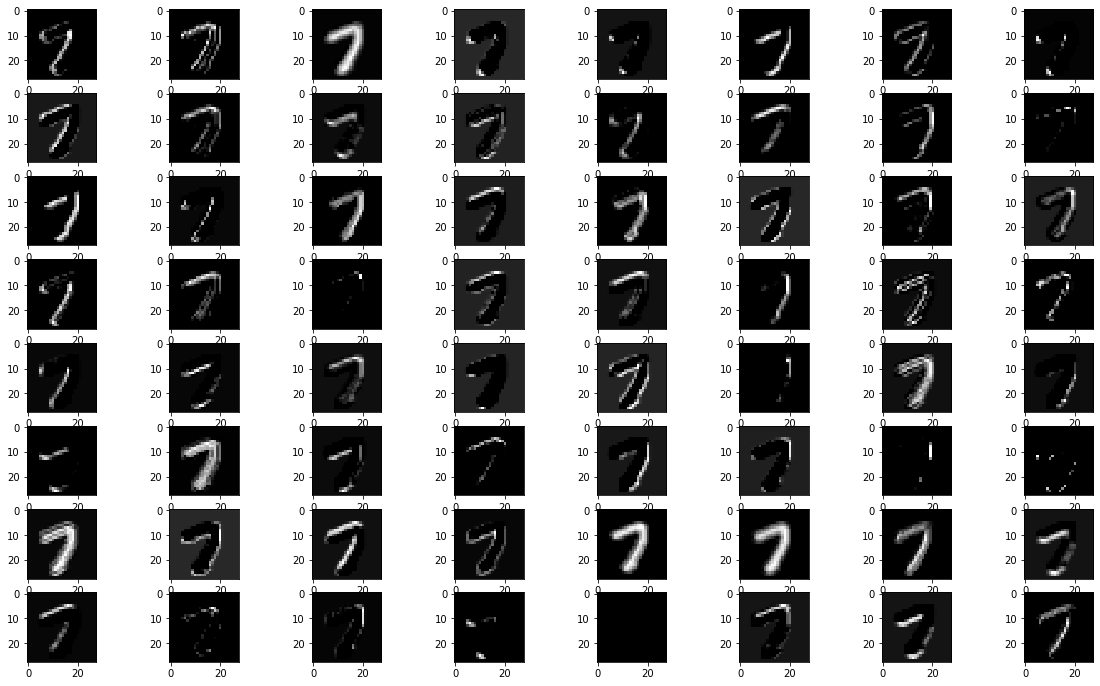

In [27]:
# 첫 번째 Conv2D 층이 이미지를 통과시키면 활성화되는 정도를 확인해보겠습니다. 
display_activation(activations, 8, 8, 1)

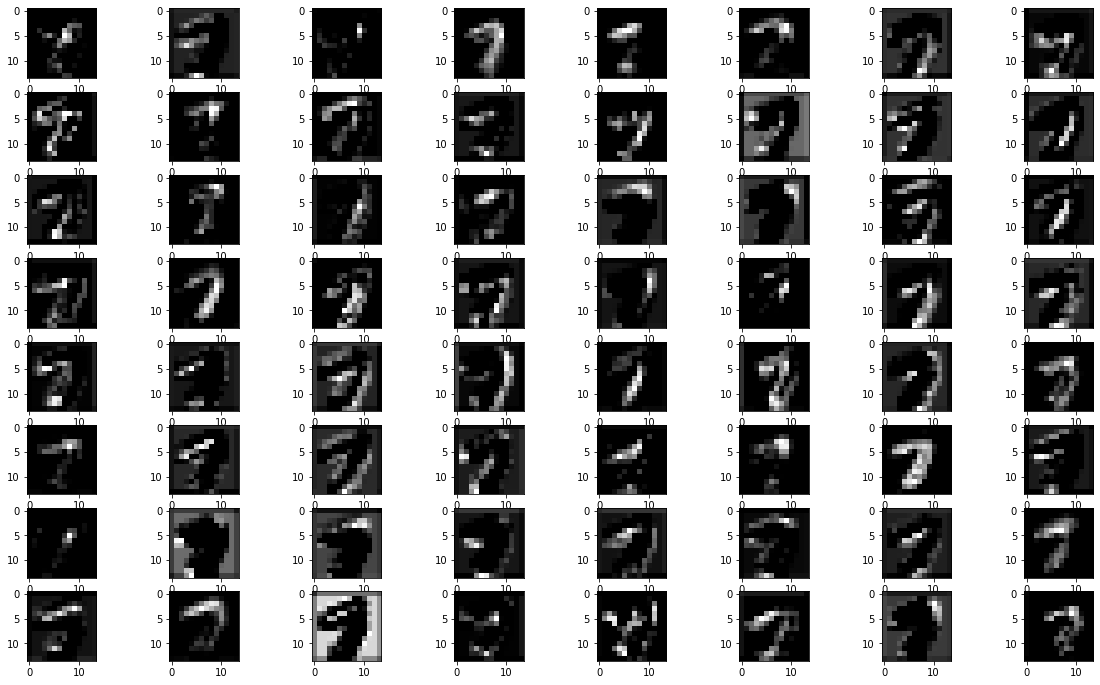

In [22]:
# 두 번째 Conv2D 층이 이미지를 통과시키면 활성화되는 정도를 확인해보겠습니다. 
display_activation(activations, 8, 8, 4)

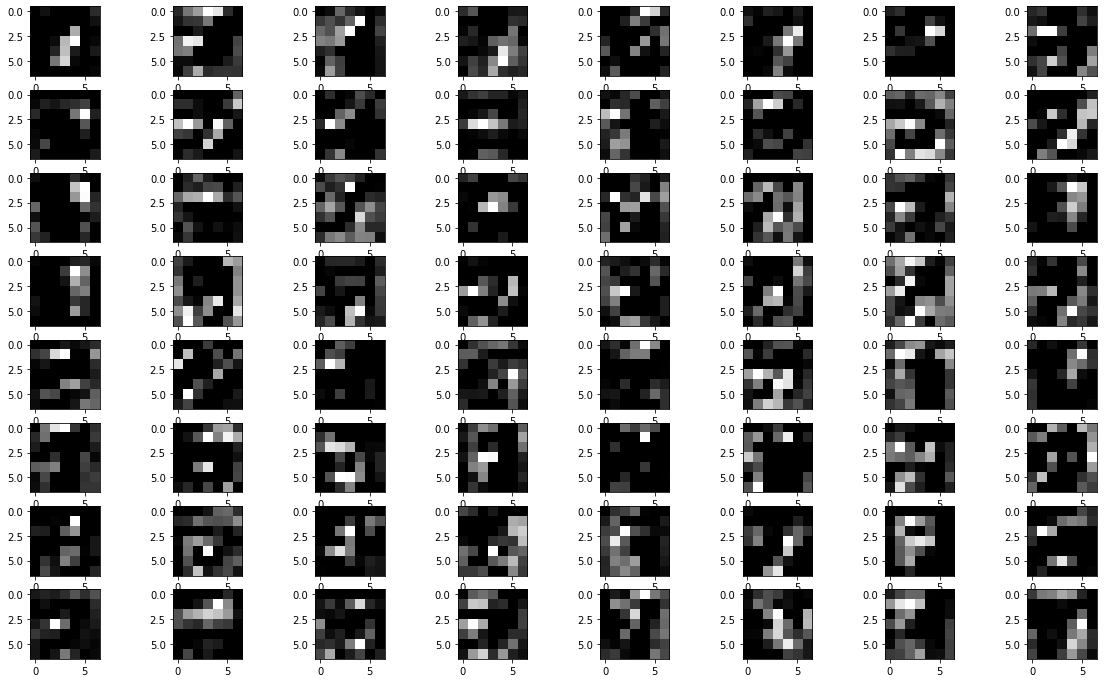

In [23]:
# 세 번째 Conv2D 층이 이미지를 통과시키면 활성화되는 정도를 확인해보겠습니다. 
display_activation(activations, 8, 8, 7)

층이 깊어갈수록 데이터가 단순화 됨을 알 수 있습니다. 